In [1]:
import sys
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import subtle.subtle_io as suio
import subtle.subtle_preprocess as sup
import subtle.subtle_plot as suplot
import nibabel as nib
sys.path.insert(0, '/home/subtle/jon/tools/SimpleElastix/build/SimpleITK-build/Wrapping/Python/Packaging/build/lib.linux-x86_64-3.5/SimpleITK')
import SimpleITK as sitk

Using TensorFlow backend.
/home/subtle/tensorflow/lib/python3.5/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [2]:
base_path = '/home/subtle/Data/SubtleGAD_Hoag/101_Id_003/Mri_Brain_W_Wo_Contrast_-_0'
path_zero, path_low, path_full = suio.get_dicom_dirs(base_path)

In [3]:
ims_zero, hdr_zero = suio.dicom_files(path_zero, normalize=False)
ims_low, hdr_low = suio.dicom_files(path_low, normalize=False)
ims_full, hdr_full = suio.dicom_files(path_full, normalize=False)

In [4]:
pixel_spacing_zero = suio.get_pixel_spacing(hdr_zero)
pixel_spacing_low = suio.get_pixel_spacing(hdr_low)
pixel_spacing_full = suio.get_pixel_spacing(hdr_full)

In [5]:
ims = np.stack((ims_zero, ims_low, ims_full), axis=1)

In [6]:
mask = sup.mask_im(ims, threshold=.03)
print(mask.shape)

(224, 3, 320, 320)


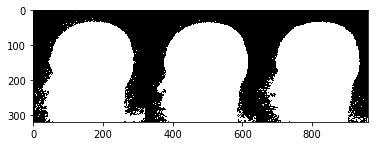

In [9]:
suplot.imshowtile(mask[100,...].squeeze().transpose((1,2,0)))

In [41]:
ims_zero_nifti = nib.load('/raid/jon/data_full_hoag/data/101_Id_003Mri_Brain_W_Wo_Contrast_-_0/2_sag_mprage.nii.gz').get_fdata()
ims_low_nifti = nib.load('/raid/jon/data_full_hoag/data/101_Id_003Mri_Brain_W_Wo_Contrast_-_0/9_sag_mprage_we_10_percent.nii.gz').get_fdata()
ims_full_nifti = nib.load('/raid/jon/data_full_hoag/data/101_Id_003Mri_Brain_W_Wo_Contrast_-_0/13_sag_mprage_we_post.nii.gz').get_fdata()
ims_nifti = np.stack((ims_zero_nifti, ims_low_nifti, ims_full_nifti), axis=1)[:,:,::-1,::-1].transpose((0,1,3,2))

ims_zero_brain_nifti = nib.load('/raid/jon/data_full_hoag/data/101_Id_003Mri_Brain_W_Wo_Contrast_-_0/brain_2_sag_mprage.nii.gzBrainExtractionBrain.nii.gz').get_fdata()
ims_low_brain_nifti = nib.load('/raid/jon/data_full_hoag/data/101_Id_003Mri_Brain_W_Wo_Contrast_-_0/brain_9_sag_mprage_we_10_percent.nii.gzBrainExtractionBrain.nii.gz').get_fdata()
ims_full_brain_nifti = nib.load('/raid/jon/data_full_hoag/data/101_Id_003Mri_Brain_W_Wo_Contrast_-_0/brain_13_sag_mprage_we_post.nii.gzBrainExtractionBrain.nii.gz').get_fdata()
ims_brain_nifti = np.stack((ims_zero_brain_nifti, ims_low_brain_nifti, ims_full_brain_nifti), axis=1)[:,:,::-1,::-1].transpose((0,1,3,2))


(224, 320, 320)


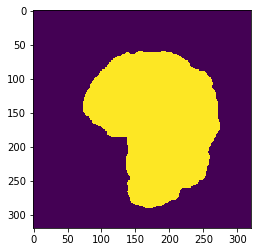

In [83]:
ims_brain_mask_nifti = ims_brain_nifti != 0

ims_brain_mask_nifti_single = np.sum(ims_brain_nifti, axis=1)!=0
print(ims_brain_mask_nifti_single.shape)
plt.imshow(ims_brain_mask_nifti_single[100,...])

(224, 3, 320, 320)


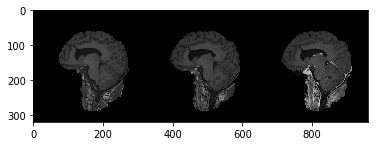

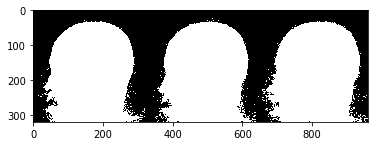

In [87]:
suplot.imshowtile(ims_brain_mask_nifti_single[100,...][:,:,None]*ims_nifti[100,...].squeeze().transpose((1,2,0)))
mask_nifti = sup.mask_im(ims_nifti, threshold=.03)
print(mask_nifti.shape)
plt.figure()
suplot.imshowtile(mask_nifti[100,...].squeeze().transpose((1,2,0)))

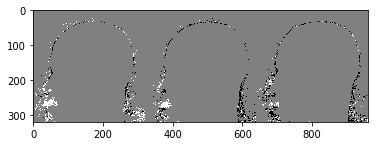

In [32]:
suplot.imshowtile((mask[100,...]*1 - 1*mask_nifti[100,...]).squeeze().transpose((1,2,0)))

In [63]:
sim0 = sitk.GetImageFromArray(ims_zero)
sim1 = sitk.GetImageFromArray(ims_full)
sim0.SetSpacing(pixel_spacing_zero)
sim1.SetSpacing(pixel_spacing_full)
param_map = sitk.GetDefaultParameterMap('rigid')

ef = sitk.ElastixImageFilter()
ef.SetFixedImage(sim0)
ef.SetMovingImage(sim1)
ef.SetParameterMap(param_map)
ef.Execute()

<SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7f58bbf21c60> >

(224, 320, 320)


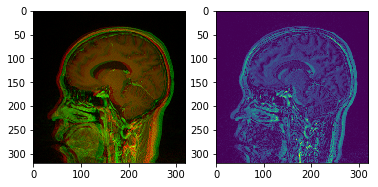

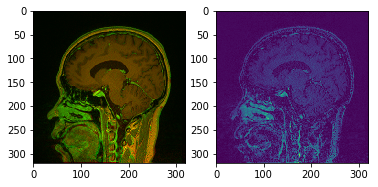

In [64]:
sim_out = ef.GetResultImage()
param_map_out = ef.GetTransformParameterMap()
im_out = sitk.GetArrayFromImage(sim_out)
print(im_out.shape)
plt.figure()
suplot.imshowreg(ims_zero[100,...], ims_full[100,...])
plt.figure()
suplot.imshowreg(ims_zero[100,...], im_out[100,...])


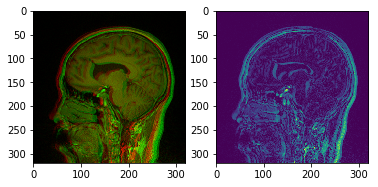

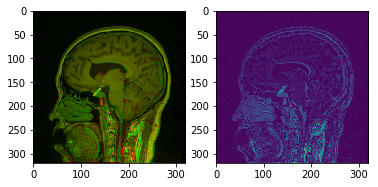

In [72]:
sim0 = sitk.GetImageFromArray(ims_nifti[:,0,:,:].squeeze())
sim1 = sitk.GetImageFromArray(ims_nifti[:,1,:,:].squeeze())
sim0.SetSpacing(pixel_spacing_zero)
sim1.SetSpacing(pixel_spacing_low)
ef = sitk.ElastixImageFilter()
ef.SetFixedImage(sim0)
ef.SetMovingImage(sim1)
ef.SetParameterMap(param_map)
ef.Execute()

tf = sitk.TransformixImageFilter()
tf.SetTransformParameterMap(param_map_out)
tf.SetMovingImage(sim1)
tf.Execute()
im_out_nifti = sitk.GetArrayFromImage(tf.GetResultImage())
plt.figure()
suplot.imshowreg(ims_nifti[100,0,...], ims_nifti[100,1,...].squeeze())
plt.figure()
suplot.imshowreg(ims_nifti[100,0,...], im_out_nifti[100,...])


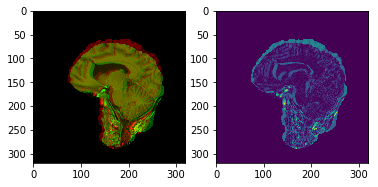

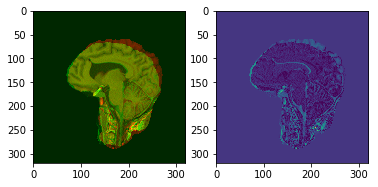

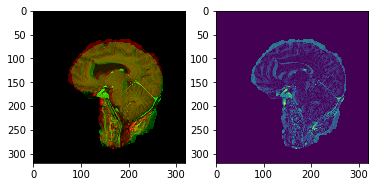

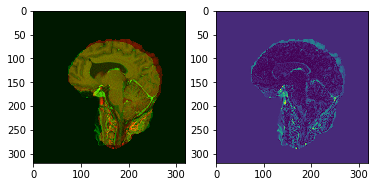

In [76]:
sim1 = sitk.GetImageFromArray(ims_brain_nifti[:,1,:,:].squeeze())
sim1.SetSpacing(pixel_spacing_low)

tf = sitk.TransformixImageFilter()
tf.SetTransformParameterMap(param_map_out)
tf.SetMovingImage(sim1)
tf.Execute()
im_out_brain_nifti = sitk.GetArrayFromImage(tf.GetResultImage())
plt.figure()
suplot.imshowreg(ims_brain_nifti[100,0,...], ims_brain_nifti[100,1,...].squeeze())
plt.figure()
suplot.imshowreg(ims_brain_nifti[100,0,...], im_out_brain_nifti[100,...])


sim1 = sitk.GetImageFromArray(ims_brain_nifti[:,2,:,:].squeeze())
sim1.SetSpacing(pixel_spacing_full)
tf = sitk.TransformixImageFilter()
tf.SetTransformParameterMap(param_map_out)
tf.SetMovingImage(sim1)
tf.Execute()
im_out_brain_nifti = sitk.GetArrayFromImage(tf.GetResultImage())
plt.figure()
suplot.imshowreg(ims_brain_nifti[100,0,...], ims_brain_nifti[100,2,...].squeeze())
plt.figure()
suplot.imshowreg(ims_brain_nifti[100,0,...], im_out_brain_nifti[100,...])


In [70]:
sitk.PrintParameterMap(sitk.GetDefaultParameterMap("rigid"))

In [ ]:
ims_masked = ims * mask
plt.figure(figsize=(10,8))
suplot.imshowtile(ims[100,...].squeeze().transpose((1,2,0)))
plt.figure(figsize=(10,8))
suplot.imshowtile(ims_masked[100,...].squeeze().transpose((1,2,0)))

plt.figure(figsize=(10,8))
suplot.imshowtile(abs(ims-ims_masked)[100,...].squeeze().transpose((1,2,0)))

In [ ]:
levels = 1024
points = 50
mean_intensity = True
ims_masked_scaled = ims.copy()
ims_masked_scaled[:,1,:,:] = sup.scale_im(ims_masked[:,0,:,:], ims_masked[:,1,:,:], levels, points, mean_intensity)
ims_masked_scaled[:,2,:,:] = sup.scale_im(ims_masked[:,0,:,:], ims_masked[:,2,:,:], levels, points, mean_intensity)


In [ ]:
# histogram normalization is broken because of fat signal
# don't use
plt.figure(figsize=(10,8))
suplot.imshowtile(ims_masked[100,...].squeeze().transpose((1,2,0)))
plt.figure(figsize=(10,8))
suplot.imshowtile(ims_masked_scaled[100,...].squeeze().transpose((1,2,0)))


### check registration with and without mask
doesn't seem to matter

In [ ]:
# registration without mask
spars = sitk.GetDefaultParameterMap('rigid')
im_low_reg, spars_low_out = sup.register_im(ims[:,0,:,:], ims[:,1,:,:], param_map=spars, verbose=True, im_fixed_spacing=pixel_spacing_zero, im_moving_spacing=pixel_spacing_low)
im_full_reg, spars_full_out = sup.register_im(ims[:,0,:,:], ims[:,2,:,:], param_map=spars, verbose=True, im_fixed_spacing=pixel_spacing_zero, im_moving_spacing=pixel_spacing_low)

plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(abs(ims[:,1,:,:] - ims[:,0,:,:])[100,...].squeeze())
plt.subplot(1,3,2)
plt.imshow(abs(im_low_reg - ims[:,0,:,:])[100,...].squeeze())
plt.subplot(1,3,3)
plt.imshow(abs(im_low_reg - ims[:,1,:,:])[100,...].squeeze())


plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(abs(ims[:,2,:,:] - ims[:,0,:,:])[100,...].squeeze())
plt.subplot(1,3,2)
plt.imshow(abs(im_full_reg - ims[:,0,:,:])[100,...].squeeze())
plt.subplot(1,3,3)
plt.imshow(abs(im_full_reg - ims[:,2,:,:])[100,...].squeeze())

In [ ]:
# registration with mask
spars = sitk.GetDefaultParameterMap('rigid')
im_low_reg, spars_low_out = sup.register_im(ims_masked[:,0,:,:], ims_masked[:,1,:,:], param_map=spars, verbose=True, im_fixed_spacing=pixel_spacing_zero, im_moving_spacing=pixel_spacing_low)
im_full_reg, spars_full_out = sup.register_im(ims_masked[:,0,:,:], ims_masked[:,2,:,:], param_map=spars, verbose=True, im_fixed_spacing=pixel_spacing_zero, im_moving_spacing=pixel_spacing_low)

plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(abs(ims_masked[:,1,:,:] - ims_masked[:,0,:,:])[100,...].squeeze())
plt.subplot(1,3,2)
plt.imshow(abs(im_low_reg - ims_masked[:,0,:,:])[100,...].squeeze())
plt.subplot(1,3,3)
plt.imshow(abs(im_low_reg - ims_masked[:,1,:,:])[100,...].squeeze())


plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(abs(ims_masked[:,2,:,:] - ims_masked[:,0,:,:])[100,...].squeeze())
plt.subplot(1,3,2)
plt.imshow(abs(im_full_reg - ims_masked[:,0,:,:])[100,...].squeeze())
plt.subplot(1,3,3)
plt.imshow(abs(im_full_reg - ims_masked[:,2,:,:])[100,...].squeeze())


In [ ]:
ims_masked_reg = ims_masked.copy()
ims_masked_reg[:,1,:,:] = im_low_reg
ims_masked_reg[:,2,:,:] = im_full_reg

In [ ]:
## check normalization
ims_masked_reg_jnrm = sup.normalize_data(ims_masked_reg.transpose((0,2,3,1)), verbose=True, axis=(0,1,2,3)).transpose((0,3,1,2))
plt.figure(figsize=(10,8))
suplot.imshowtile(ims_masked_reg_jnrm[100,...].squeeze().transpose((1,2,0)))

ims_masked_reg_nrm = sup.normalize_data(ims_masked_reg.transpose((0,2,3,1)), verbose=True, axis=(0,1,2)).transpose((0,3,1,2))
plt.figure(figsize=(10,8))
suplot.imshowtile(ims_masked_reg_nrm[100,...].squeeze().transpose((1,2,0)))


In [ ]:
data = suio.load_file('/raid/jon/data_full_hoag/data/Id0032Neuro_Brain-16479659.npy')
print(data.shape)
data_pred = suio.load_file('/raid/jon/predictions/test_hoag_fix_scale/Id0032Neuro_Brain-16479659_predict_test_hoag_fix_scale.npy')
print(data_pred.shape)
idx=115
plt.figure(figsize=(20,10))
suplot.imshow3(np.stack((ims[idx,0,:,:], ims[idx,1,:,:], ims[idx,2,:,:], data_pred[idx,:,:,0]), axis=0))

plt.figure(figsize=(20,10))
suplot.imshow3(np.stack((data[idx,0,:,:], data[idx,1,:,:], data[idx,2,:,:], data_pred[idx,:,:,0]), axis=0))

In [ ]:
plt.figure(figsize=(20,10))
suplot.imshow3(np.stack((abs(im_full_reg[idx,:,:]), abs(data[idx,2,:,:]), abs(data_pred[idx,:,:,0])), axis=0))

In [ ]:
spars = sitk.GetDefaultParameterMap('rigid')
spars2 = spars_out[0]
for key in spars.keys():
    print(key, spars[key])
print()
for key in spars2.keys():
    print(key, spars2[key])
